# Orchestrating Data Pipelines with Large Language Models

Read the blog post about this notebook here:


Install the dependencies

In [4]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph networkx matplotlib langchain pydantic

Below I have create some dummy amazon scraping tools. The tools do not actually scrape amazon but define the input and output schemas that an actual amazon scraper would have. This is enough for our demonstation as we do not actually run the tools

In [5]:
import datetime
from typing import List, Optional
from pydantic import BaseModel, Field, HttpUrl
from langchain.tools import StructuredTool

# --- Amazon Structures ---

class AmazonProductScraperInputs(BaseModel):
    product_url: HttpUrl = Field(
        ...,
        description="Amazon product URL. Example: https://www.amazon.com/dp/B09B2SBHQK or https://www.amazon.in/dp/B0BY8MXBPM"
    )

class AmazonProduct(BaseModel):
    title: str = Field(..., description="Product title")
    url: HttpUrl = Field(
        ...,
        description="Canonical Amazon product URL. Example: https://www.amazon.com/dp/B09B2SBHQK"
    )
    image_urls: List[HttpUrl] = Field(
        ...,
        description="List of product image URLs. Example: ['https://m.media-amazon.com/images/I/71xb2xkN5qL._AC_SL1500_.jpg']"
    )
    price: float = Field(..., description="Pricing details of the product")
    rating: Optional[float] = Field(None, description="Product rating (0-5)")
    review_count: Optional[int] = Field(0, description="Number of reviews")
    availability: Optional[str] = Field(None, description="Product availability status (e.g., 'In Stock', 'Currently unavailable')")
    features: Optional[List[str]] = Field(None, description="List of key product features (often bullet points)")
    seller: Optional[str] = Field(None, description="Seller name (e.g., 'Amazon.com', 'Sold by X, Fulfilled by Amazon')")
    asin: str = Field(..., description="Amazon Standard Identification Number (ASIN)")

def amazon_product_scraper(item:AmazonProductScraperInputs) -> AmazonProduct:
    """
    Scraper to fetch a product's information from the product page of Amazon.
    """
    return AmazonProduct(
        title="Echo Dot (5th Gen, 2022 release) | Smart speaker with Alexa | Charcoal",
        url="https://www.amazon.com/dp/B09B2SBHQK", # Example URL
        image_urls=["https://m.media-amazon.com/images/I/71xb2xkN5qL._AC_SL1500_.jpg"], # Example URL
        price=49.99,
        rating=4.7,
        review_count=156000,
        availability="In Stock",
        features=["Our best sounding Echo Dot yet", "Control music with your voice", "Ask Alexa for weather, news, timers, etc.", "Control compatible smart home devices"],
        seller="Amazon.com",
        asin="B09B2SBHQK" # Matches example URL
    )

class AmazonPLPInputs(BaseModel):
    product_listing_url: HttpUrl = Field(
        ...,
        description="""Amazon product listing page URL (search results, category/browse node).
        Example .com Search URL: https://www.amazon.com/s?k=echo+dot
        Example .com Browse Node URL: https://www.amazon.com/gp/browse.html?node=172282
        Example .in Search URL: https://www.amazon.in/s?k=smartphones&ref=nb_sb_noss_2
        Example .in Browse Node URL: https://www.amazon.in/gp/browse.html?node=1389401031"""
    )
    max_count: Optional[int] = Field(None, description="Limit the number of products that are returned")

class AmazonPLPItem(BaseModel):
    url: HttpUrl = Field(
        ...,
        description="URL of the Amazon product found on the listing page. Example: https://www.amazon.com/dp/B09B2SBHQK"
    )

def amazon_plp_scraper(item:AmazonPLPInputs) -> List[AmazonPLPItem]:
    """
    Scraper to fetch all products from an Amazon product listing page.
    """
    return [
        AmazonPLPItem(url="https://www.amazon.com/dp/B09B2SBHQK"), # Example URL 1
        AmazonPLPItem(url="https://www.amazon.com/dp/B09B2SWS7B")  # Example URL 2 (different color maybe)
        ]


Set the OpenAI key

In [6]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In the cell below, I am obtaining the input and output schemas of the tools in tool_list in json format. This makes it easy for me to store the tool details in a database for later retreival

In [17]:
import inspect
import typing
import json
from langchain_core.utils.function_calling import convert_to_openai_tool
tool_list = [amazon_product_scraper, amazon_plp_scraper]

def get_output_details_for_tool(tool):
    signature = inspect.signature(tool)
    return_annotation = signature.return_annotation

    # Check if the return annotation is a generic type like List[Model]
    origin = typing.get_origin(return_annotation)
    if origin is list or origin is List: # Handles both list and typing.List
        args = typing.get_args(return_annotation)
        if args:
            inner_type = args[0]
            # Check if the inner type is a Pydantic model
            if inspect.isclass(inner_type) and issubclass(inner_type, BaseModel):
                return inner_type.model_json_schema()
    # Optional: Handle case where the function returns a single Pydantic model directly
    elif inspect.isclass(return_annotation) and issubclass(return_annotation, BaseModel):
        return return_annotation.model_json_schema()
    raise Exception("Could not determine output format of tool")

def get_openai_spec(tool):
    open_ai_spec = convert_to_openai_tool(i)
    open_ai_spec['function']['description'] = open_ai_spec['function'].get('description','')+f"""

The output format is:
{json.dumps(get_output_details_for_tool(tool))}

    """
    return open_ai_spec

tool_details = []
for i in tool_list:
    tool_details.append({
        "openai_spec": get_openai_spec(i),
        "output_details": get_output_details_for_tool(i)
    })

Setup the GPT 4 model with tools

In [19]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools([i['openai_spec'] for i in tool_details], parallel_tool_calls=False)

Define the custom tool call executer which mocks tool calls

In [20]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage

def get_tool_schema(ai_message: AIMessage) -> str:
    if not ai_message.tool_calls:
        raise Exception("The given AI message has no tool calls")
    tool_call = ai_message.tool_calls[0]
    tool = next((x for x in tool_details if x['openai_spec']['function']['name'] == tool_call['name']), None)
    if not tool:
        raise Exception("Tool not found")
    return tool

def mock_tool_call(tool_schema):

    a = f'''
Create a dummy output for the tool {tool_schema['openai_spec']['function']['name']} 

the function's input schema is

'''+json.dumps(tool_schema['openai_spec']['function']['parameters'])+"""

and  output schema is

"""+json.dumps(tool_schema['output_details'])+"""

please only provide the output in json format
"""    
    return llm.invoke(a)

def get_json_tool_output(ai_message):
    content = ai_message.content
    json_start_index = content.find('{')
    json_end_index = content.rfind('}')
    try:
        return json.loads(content[json_start_index: json_end_index+1])
    except Exception as e:
        print("Could not parse content : "+content)
        return content

def get_tool_message(ai_message, dummy_output_message):
    tool_call = ai_message.tool_calls[0]
    return ToolMessage(name=tool_call['name'], content=dummy_output_message.content, tool_call_id=tool_call['id'])

from pydantic import BaseModel, Field
from typing import Any, Dict, List, Literal

class OrpheusToolCall(BaseModel):
    name: str
    input: Any = Field(..., description="Input JSON for the tool call")
    output: Any = Field(..., description="Output JSON from the tool call")

def get_orpheus_tool_call(ai_message, json_tool_output):
    tool_call = ai_message.tool_calls[0]
    return OrpheusToolCall(
        name=tool_call['name'],
        input=tool_call['args'],
        output=json_tool_output
    )

Setup the LangGraph graph

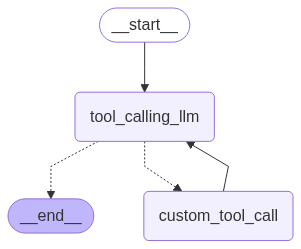

In [21]:
from langgraph.graph import MessagesState

from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    orpheus_tool_calls: List[OrpheusToolCall] = Field(default_factory=list)

def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def custom_tool_call(state: MessagesState):
    ai_message = state['messages'][-1]
    tool_schema = get_tool_schema(ai_message)
    dummy_output_message = mock_tool_call(tool_schema)
    json_tool_output = get_json_tool_output(dummy_output_message)
    tool_message = get_tool_message(ai_message, dummy_output_message)
    orpheus_tool_call = get_orpheus_tool_call(ai_message, json_tool_output)
    updated_orpheus_tool_calls = state.get('orpheus_tool_calls', []) + [orpheus_tool_call]
    return {"messages":[tool_message], "orpheus_tool_calls": updated_orpheus_tool_calls}

def is_tool_call(state) -> Literal["custom_tool_call", END]:
    latest_message = state['messages'][-1]
    if latest_message.tool_calls:
        return "custom_tool_call"
    return END
    

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("custom_tool_call", custom_tool_call)
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", is_tool_call)
builder.add_edge("custom_tool_call", "tool_calling_llm")
graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Creating the system prompt for the agent

In [22]:
system_prompt = [SystemMessage(content="""
You are an assistant for orchestration scraping or other long running tasks.

You need to understand the users input and use the appropriate scraper to fetch the desired information. 
In some cases it will require more than one scraper to get the desired results.
Users might ask for a specific amount of data, if insufficient data is present that is not a problem. Do not mention it to the user.

The user query is:

""")]

Invoking the agent with the user prompt

In [23]:
messages = [
    HumanMessage(
        content="Can you get price rating and asin info from https://www.amazon.in/gp/browse.html?node=1968126031&ref_=nav_em_sbc_mfashion_innerwear_0_2_10_6 a 100 products should do",
        name="Puneet"
    )
]
state = graph.invoke(
    {"messages":system_prompt+messages},
    config={"max_iterations": 10}
)

In [24]:
from pprint import pprint

for i in state['messages']:
    pprint(i)
    print("""
    
    ===============
    
    """)

SystemMessage(content='\nYou are an assistant for orchestration scraping or other long running tasks.\n\nYou need to understand the users input and use the appropriate scraper to fetch the desired information. \nIn some cases it will require more than one scraper to get the desired results.\nUsers might ask for a specific amount of data, if insufficient data is present that is not a problem. Do not mention it to the user.\n\nThe user query is:\n\n', additional_kwargs={}, response_metadata={}, id='779d2f27-2ba2-486e-bfa3-33ec902eef2f')



    
HumanMessage(content='Can you get price rating and asin info from https://www.amazon.in/gp/browse.html?node=1968126031&ref_=nav_em_sbc_mfashion_innerwear_0_2_10_6 a 100 products should do', additional_kwargs={}, response_metadata={}, name='Puneet', id='624503e8-86be-4b33-9801-d94f85d93b0a')



    
AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_9v4VtLIf1GfRoUj3vIb1MXjo', 'function': {'arguments': '{"item":{"product_listing_ur

We will now build the function call chain using the LangGraph graph's state

In [25]:
from typing import List, Dict, Any
from collections import namedtuple

# Now stores multiple shared keys/values
ChainLink = namedtuple("ChainLink", ["from_tool", "to_tool", "shared_values"])

def build_function_call_chain(calls: List[Any]) -> List[ChainLink]:
    chain = []

    for i in range(len(calls) - 1):
        from_call = calls[i]
        to_call = calls[i + 1]

        shared_values = []

        # Flatten input and output for comparison
        def flatten(d: Dict, prefix: str = '') -> Dict[str, Any]:
            items = {}
            for k, v in d.items():
                if isinstance(v, dict):
                    items.update(flatten(v, prefix + k + '.'))
                else:
                    items[prefix + k] = v
            return items

        from_output_flat = flatten(from_call.output)
        to_input_flat = flatten(to_call.input)

        # Match every shared value
        for key_out, value_out in from_output_flat.items():
            for key_in, value_in in to_input_flat.items():
                if value_out == value_in:
                    shared_values.append({
                        "input_key": key_in,
                        "output_key": key_out,
                        "value": value_out
                    })

        if shared_values:
            chain.append(ChainLink(
                from_tool=from_call.name,
                to_tool=to_call.name,
                shared_values=shared_values
            ))

    return chain

In [26]:
chain = build_function_call_chain(state['orpheus_tool_calls'])

The function call chain had been created, let us now visualise it.

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_chain_matplotlib(chain):
    G = nx.DiGraph()

    edge_labels = {}

    for link in chain:
        from_tool = link.from_tool
        to_tool = link.to_tool

        label_lines = [
            f"{s['output_key']} → {s['input_key']} = {str(s['value'])[:20]}{'...' if len(str(s['value'])) > 20 else ''}"
            for s in link.shared_values
        ]
        label = "\n".join(label_lines)

        G.add_edge(from_tool, to_tool)
        edge_labels[(from_tool, to_tool)] = label

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color="lightgray", node_size=2000, font_size=10, font_weight="bold", edge_color="gray", arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Function Call Chain", fontsize=14)
    plt.axis('off')
    plt.show()

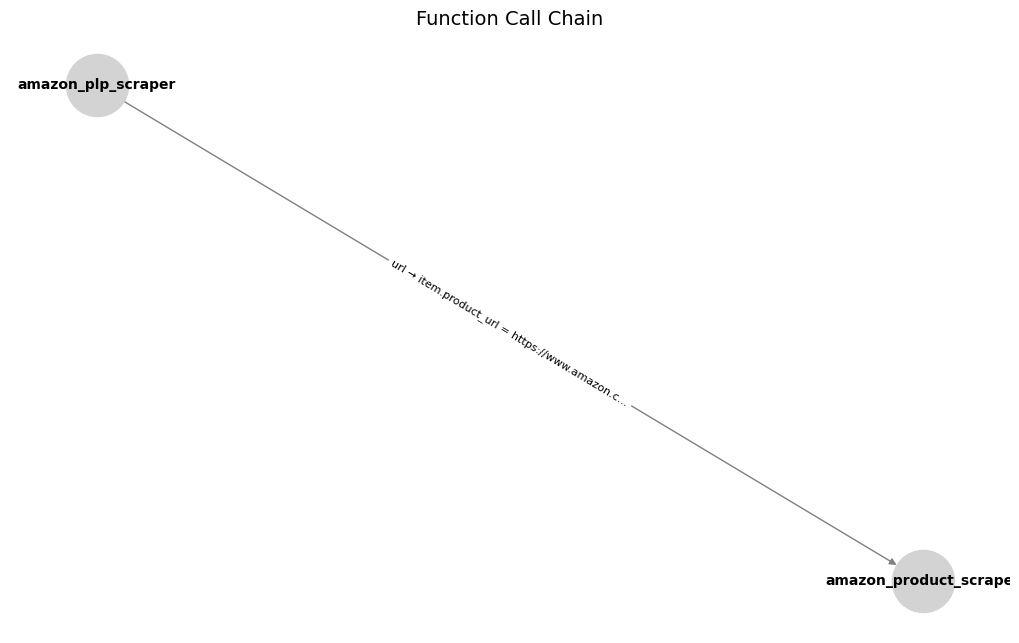

In [30]:
visualize_chain_matplotlib(chain)